In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from mpl_toolkits.mplot3d import axes3d

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})

In [4]:
from sample_3d_view import sample_sphere, sample_torus, visualize_grid_sphere, visualize_grid_torus, sample_ellipsoid

In [5]:
from local_pca_utils import make_nearest_neighbors_graph, make_tangents, make_2nd_order_laplacian,make_general_order_laplacian, make_connection

from curvature_utils import make_tangents_and_normals, get_second_fundamental_form

from tensorlaplacian_utils import get_riemannian_ricci_scalar, get_weitzenbock_operator, get_eigvals_of_weitzenbock, weitzenbock_to_bsr

In [35]:
npoints = 1000

In [36]:
data = np.loadtxt('vase2.txt')
np.random.shuffle(data)
data = data[:npoints]
data *= 10
#data_s2 *= 10
#dragon_graph = make_nearest_neighbors_graph(dragon, 30, n=22998)
graph = make_nearest_neighbors_graph(data, 6, n=npoints)


#s2_tangents, s2_normals, local_coords, s2triu, s2_h = get_second_fundamental_form(data_s2, s2_graph, 2)
_,_,_,_, h = get_second_fundamental_form(data, graph, 2)

Riem, Ric, Scal = get_riemannian_ricci_scalar(h)
origin = data


100%|██████████| 1000/1000 [00:00<00:00, 3954.54it/s]


In [37]:
weitzenbock = get_weitzenbock_operator(Riem,2,1)
block_weitzenbock = weitzenbock_to_bsr(weitzenbock)

In [38]:
block_weitzenbock

<2000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 4000 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [39]:
tangents = make_tangents(data, graph, 2)

connection = make_connection(tangents, graph)

s_1st_order_lap = make_general_order_laplacian(connection, graph, 1, sym=False, zero_trace=False)

#s_2nd_order_lap = make_2nd_order_laplacian(connection, s2_graph, sym=False, zero_trace=False)

100%|██████████| 1000/1000 [00:00<00:00, 13160.95it/s]


In [40]:
lichnerowicz = -s_1st_order_lap + block_weitzenbock

In [41]:
eigvals, eigvecs = scipy.sparse.linalg.eigs(lichnerowicz, k=2, which='SM')

In [42]:
eigvals

array([-0.02956042+0.j, -0.02956305+0.j])

In [43]:
eigvecs.shape

(2000, 2)

In [15]:
eigvecs[:,2].shape

(10000,)

In [87]:
eigvector = eigvecs[:,1].real

In [88]:
eigvector

array([-0.00415535,  0.05939328, -0.00057235, ...,  0.00140207,
        0.01046142,  0.02075164])

In [89]:
eigvector = eigvector.reshape(-1,2)

In [90]:
eigvector

array([[-0.00415535,  0.05939328],
       [-0.00057235, -0.00445379],
       [-0.00053019, -0.01890059],
       ...,
       [ 0.01453651, -0.01729316],
       [-0.00033884,  0.00140207],
       [ 0.01046142,  0.02075164]])

In [91]:
tangents.shape

(1000, 2, 3)

In [92]:
eigvector.shape

(1000, 2)

In [109]:
killingfield = np.zeros((npoints, 3))

In [110]:
npoints = 1000

In [111]:
for i in range(npoints):
    killingfield[i] = tangents[i, 0]* eigvector[i, 0] +  tangents[i, 1]* eigvector[i, 1] 

In [112]:
killingfield.shape

(1000, 3)

In [113]:
visualizer = np.zeros((npoints, 6))

In [114]:
#indices = np.where(np.logical_not((data_s2[:,0]<0)&(data_s2[:,1]>0)))

In [115]:
origin.shape

(1000, 3)

In [116]:
killingfield

array([[-0.05259812, -0.00750201,  0.02686979],
       [ 0.00406158,  0.00041364, -0.00186984],
       [ 0.01854243, -0.00364168,  0.00065552],
       ...,
       [ 0.01604025, -0.00397459, -0.01540379],
       [ 0.00121057, -0.00041586, -0.00066498],
       [ 0.01767784, -0.0046181 , -0.01436103]])

In [128]:
visualizer[:,:3] = origin
visualizer[:,3:] = killingfield*20

In [129]:
X, Y, Z, U, V, W = zip(*visualizer[:600])

In [120]:
data = np.loadtxt('vase2.txt')
data *= 10
npoints = data.shape[0]
graph = make_nearest_neighbors_graph(data, 20, n=36022)
_,_,_,_, true_h = get_second_fundamental_form(data, graph, 2)
riem, ric, sc = get_riemannian_ricci_scalar(true_h)

  0%|          | 0/1 [00:53<?, ?it/s]


KeyboardInterrupt: 

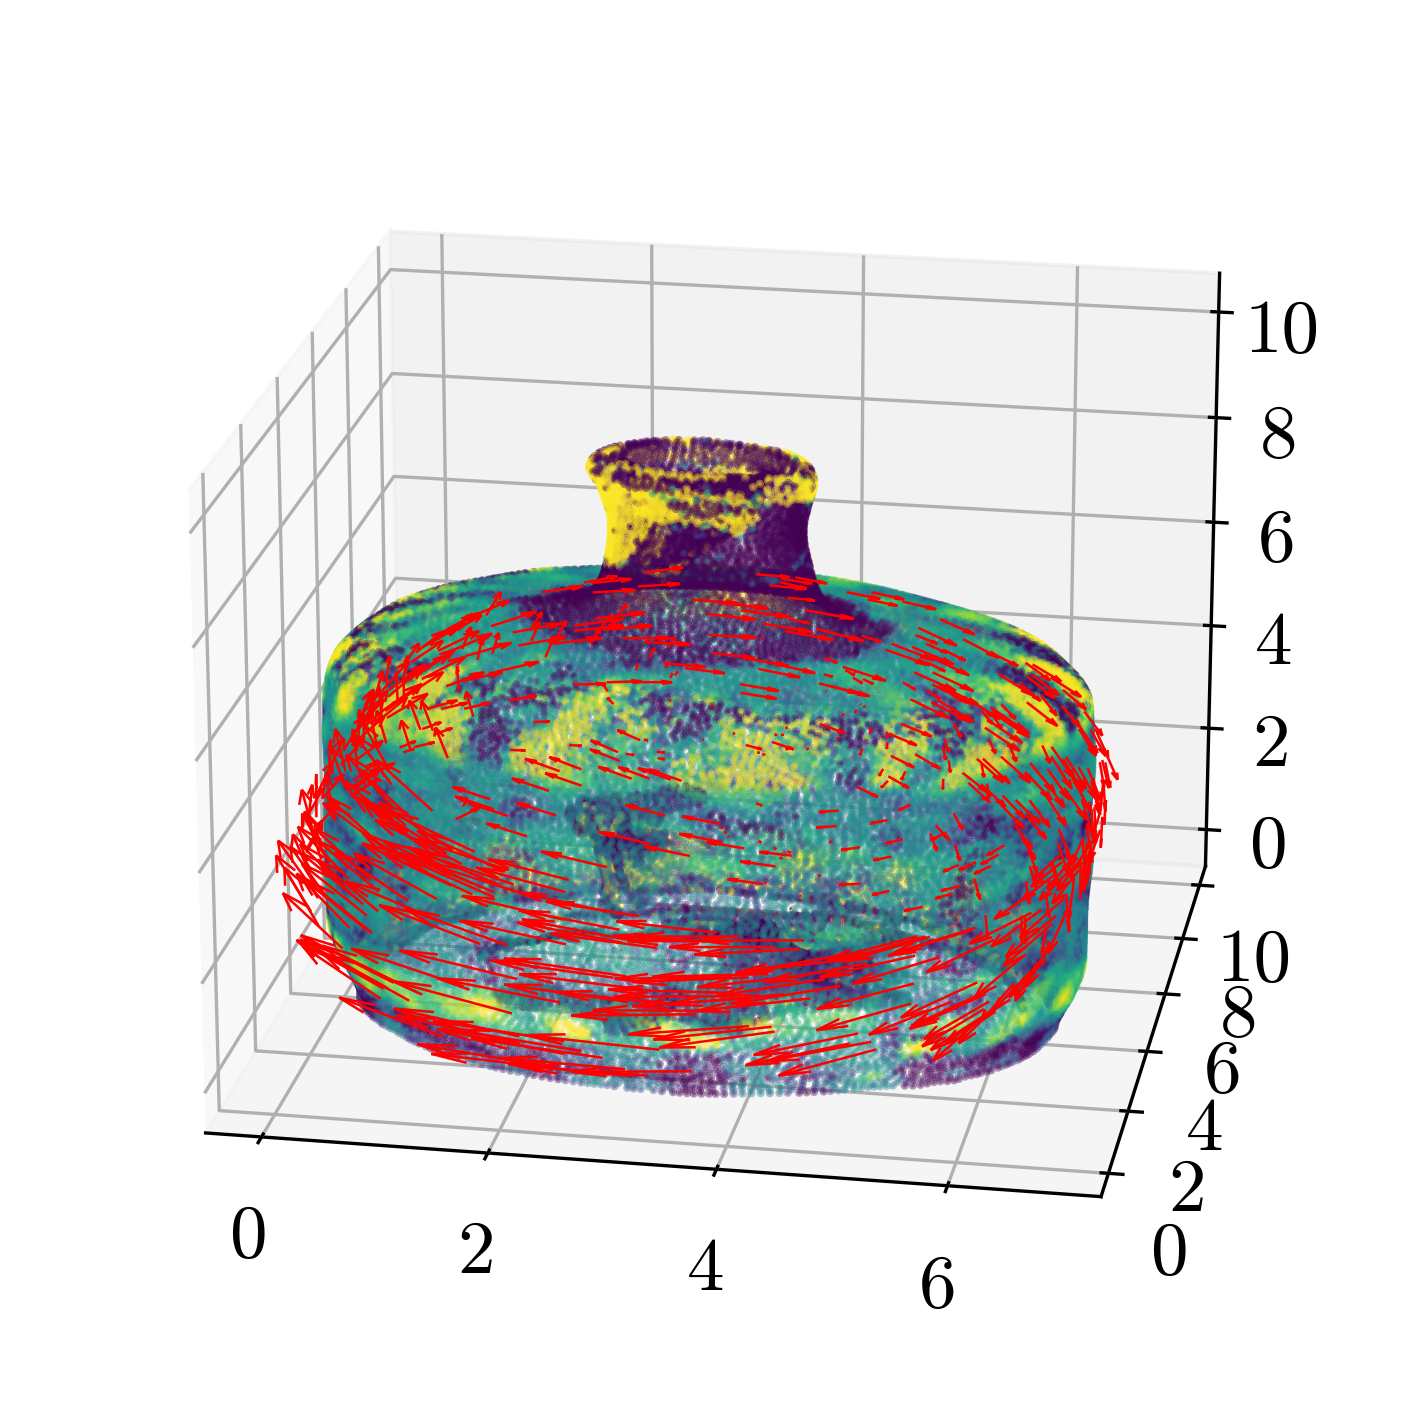

In [130]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
#ax.set_box_aspect([1,1,2])
ax.set_aspect('auto')

#fig, ax = visualize_grid_torus(30,2,1)
#ax.scatter(data[:,0], data[:, 1], data[:,2], s=1, c=sc, cmap='viridis',zorder=10, alpha=0.5)
ax.scatter(data[:,0], data[:, 2], data[:,1], s=1, c=sc, cmap='viridis',zorder=10,norm = mpl.colors.Normalize(vmin=-.1, vmax=.1, clip=False), alpha=0.4)
#ax.view_init(20, 40)
ax.view_init(20, 280)
ax.quiver(X, Y, Z, U, V, W, color="r", linewidth=0.6)

In [131]:
fig.savefig(f'../figures/KillingField_Vase_second.png')    
fig.savefig(f'../figures/KillingField_Vase_second.pdf')

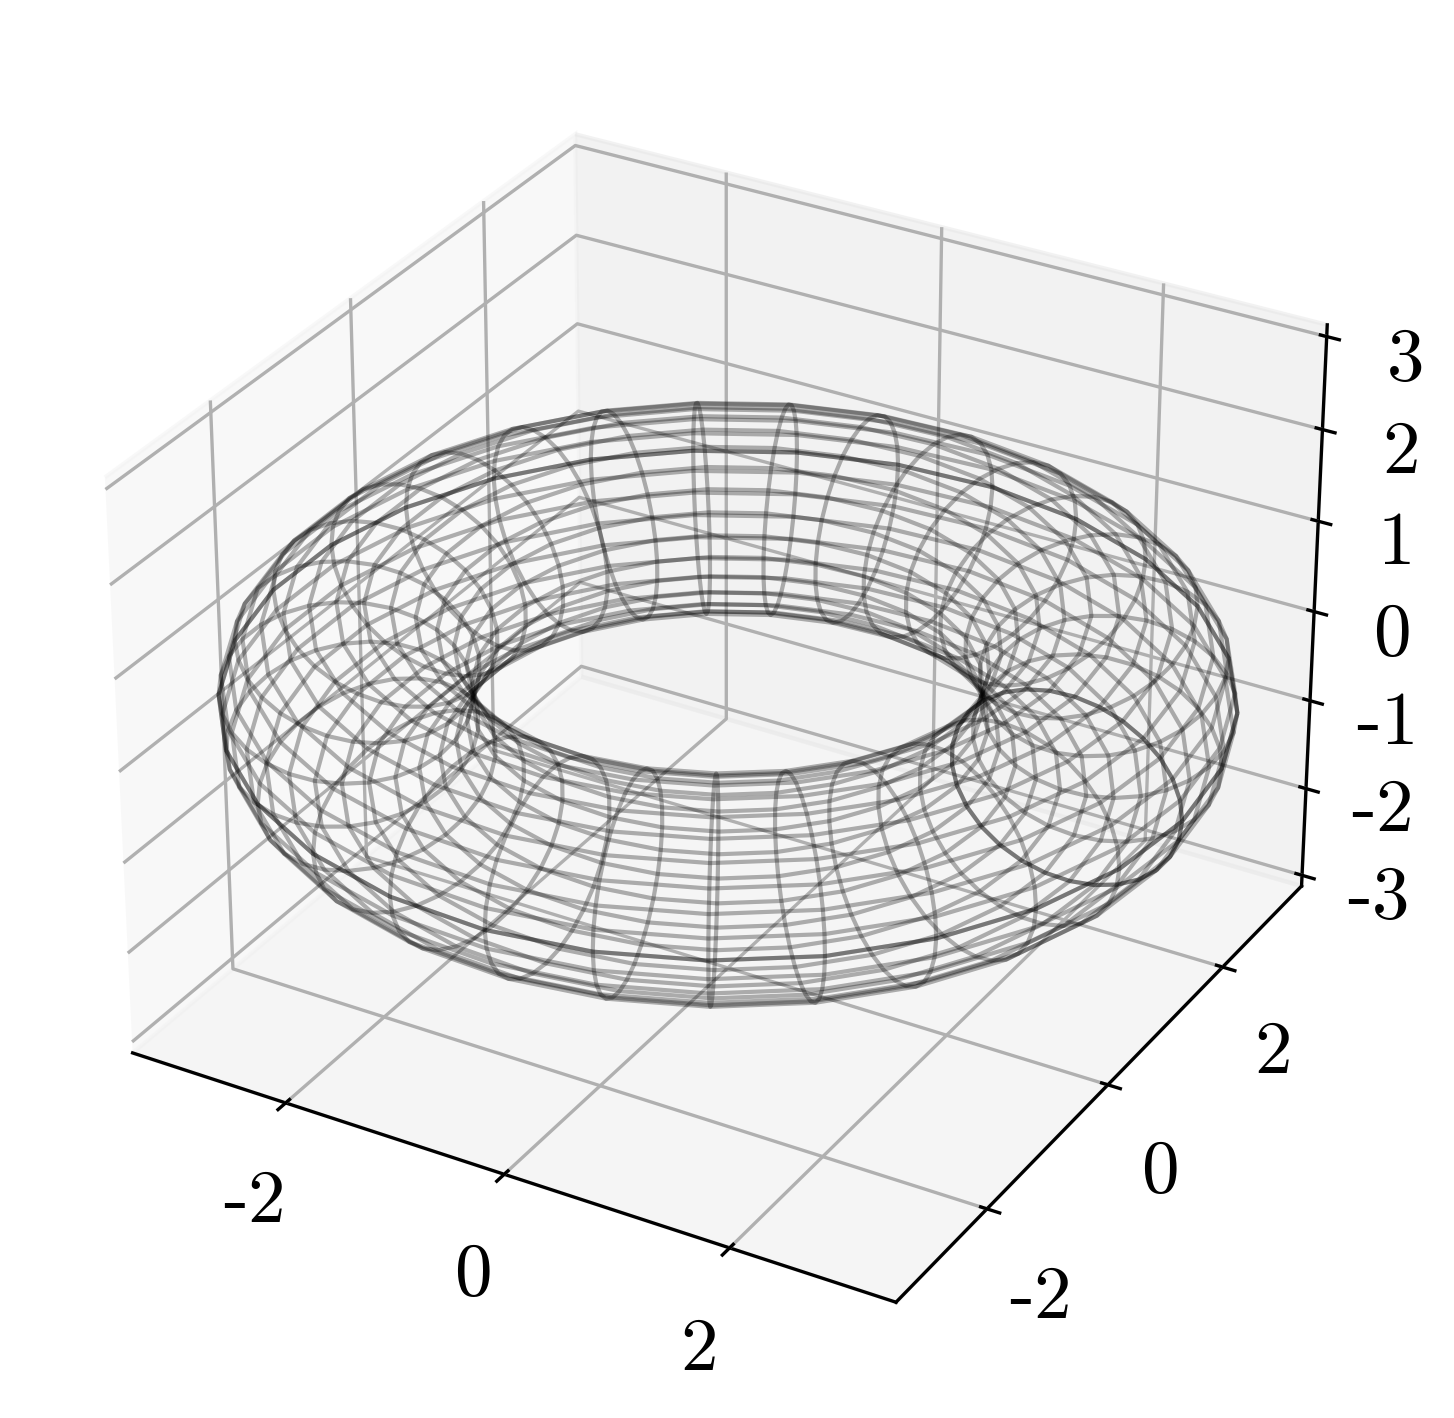

In [117]:
fig, ax = fig, ax = visualize_grid_torus(30,3,1)

In [118]:
ax.quiver(X, Y, Z, U, V, W, color="C0", linewidth=0.6)

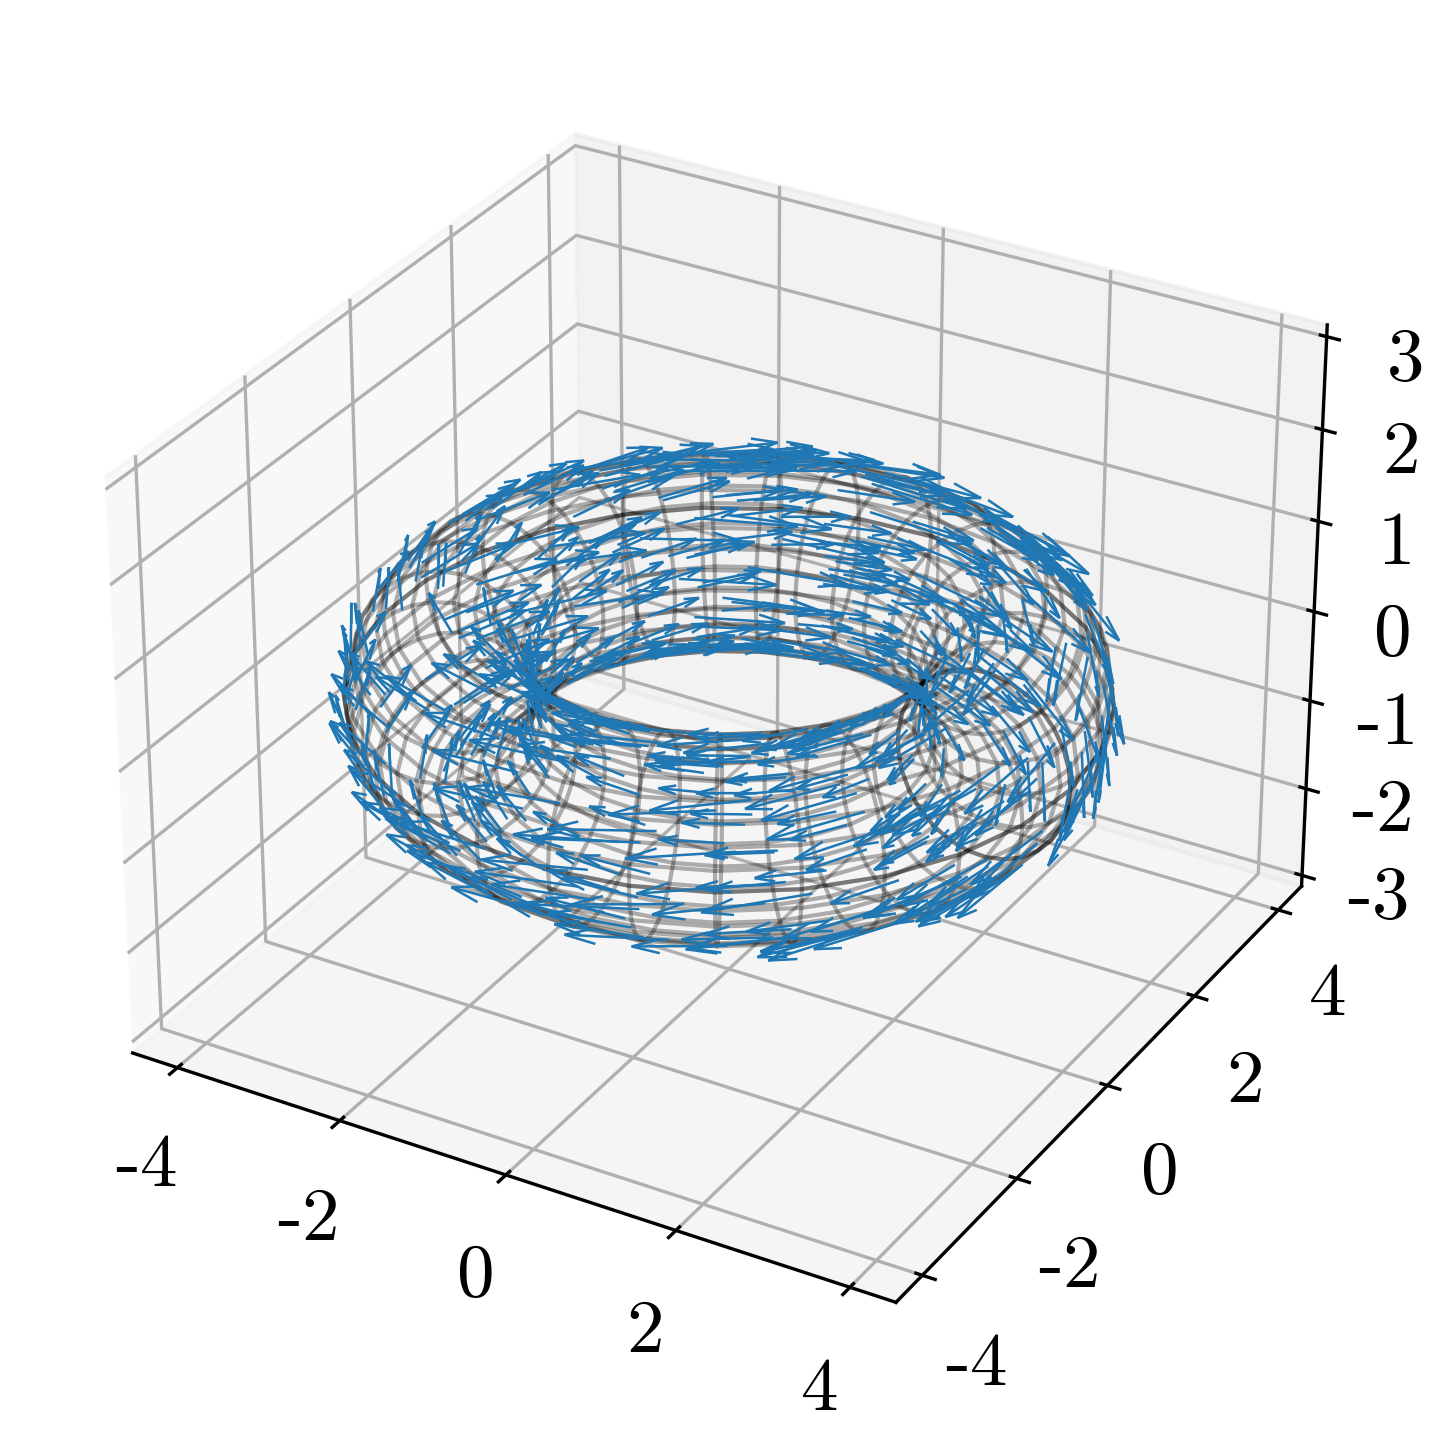

In [119]:
fig

In [120]:
fig.savefig(f'../figures/KillingField_Torus_first.png')    
fig.savefig(f'../figures/KillingField_Torus_first.pdf')